<a href="https://colab.research.google.com/github/dileep00007/Open-Source/blob/main/PneumoniaResNet50V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import zipfile as zf
files = zf.ZipFile("/content/drive/MyDrive/CTDataset.zip",'r')#Dataset path in Drive
files.extractall()
files.close()

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pathlib
dspath = '/content/CTDataset'
data_dir = pathlib.Path(dspath)

In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [5]:
batch_size = 32
img_height = 160
img_width = 160

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5509 files belonging to 2 classes.
Using 4408 files for training.


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 5509 files belonging to 2 classes.
Using 1101 files for validation.


In [8]:
class_names = val_ds.class_names
len(class_names)

2

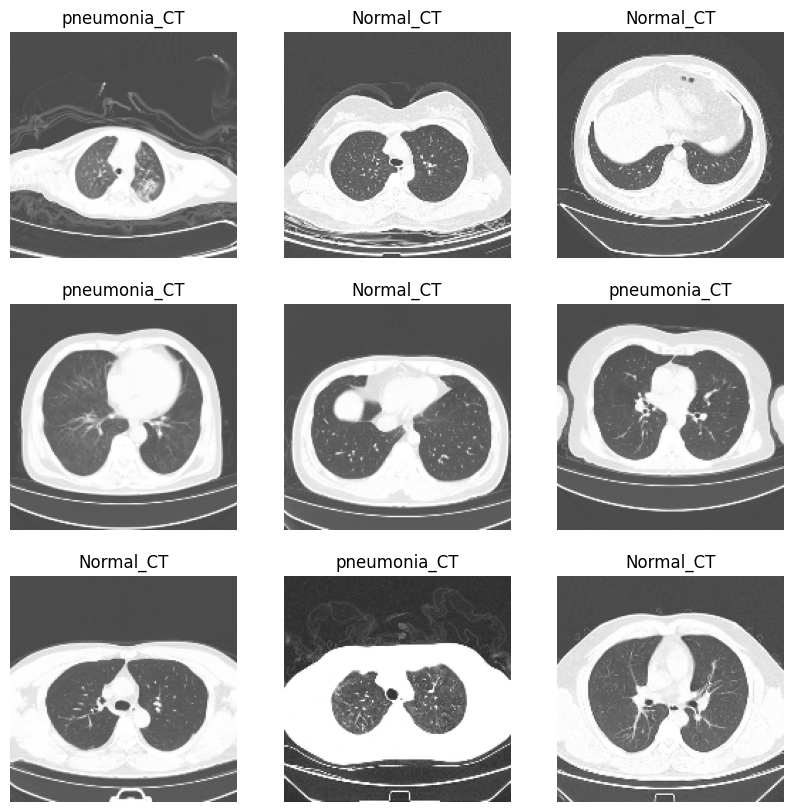

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1 )
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [10]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
base_model = tf.keras.applications.ResNet50V2(input_shape=(160,160,3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

94668760/94668760 [==============================] - 1s 0us/step


In [13]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 2048)


In [14]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [15]:
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 166, 166, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 80, 80, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 82, 82, 64)           0         ['conv1_conv[0][0]']          
                                                                                         

In [16]:
num_classes = len(class_names)

In [17]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = tf.keras.applications.vgg16.preprocess_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x) # Average pooling operation
x = tf.keras.layers.BatchNormalization()(x) # Introduce batch norm
x = tf.keras.layers.Dropout(0.2)(x)  # Regularize with dropout

# Flattening to final layer - Dense classifier with 37 units (multi-class classification)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

In [18]:
model = tf.keras.Model(inputs, outputs)

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 tf.__operators__.getitem (  (None, 160, 160, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 160, 160, 3)       0         
 )                                                               
                                                                 
 resnet50v2 (Functional)     (None, 5, 5, 2048)        23564800  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                             

In [20]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
  metrics=['accuracy'])

In [21]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=15
)

Epoch 1/15
138/138 [==============================] - 552s 4s/step - loss: 0.4381 - accuracy: 0.7936 - val_loss: 0.3344 - val_accuracy: 0.8710
Epoch 2/15
138/138 [==============================] - 530s 4s/step - loss: 0.2765 - accuracy: 0.8966 - val_loss: 0.2316 - val_accuracy: 0.9382
Epoch 3/15
138/138 [==============================] - 484s 4s/step - loss: 0.2192 - accuracy: 0.9224 - val_loss: 0.1802 - val_accuracy: 0.9564
Epoch 4/15
138/138 [==============================] - 528s 4s/step - loss: 0.1882 - accuracy: 0.9387 - val_loss: 0.1507 - val_accuracy: 0.9646
Epoch 5/15
138/138 [==============================] - 531s 4s/step - loss: 0.1650 - accuracy: 0.9469 - val_loss: 0.1269 - val_accuracy: 0.9718
Epoch 6/15
138/138 [==============================] - 527s 4s/step - loss: 0.1495 - accuracy: 0.9478 - val_loss: 0.1181 - val_accuracy: 0.9709
Epoch 7/15
138/138 [==============================] - 525s 4s/step - loss: 0.1390 - accuracy: 0.9524 - val_loss: 0.0992 - val_accuracy: 0.9773

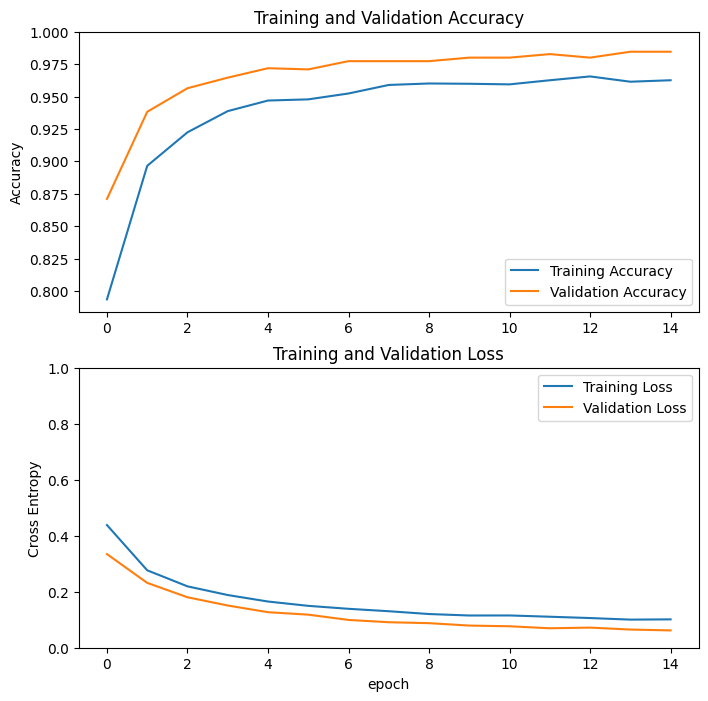

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [23]:
model.save('ResNet50V2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
